# Tour of MRI functionality in DeepInverse

This example presents the various datasets, forward physics and models available in DeepInverse for Magnetic Resonance Imaging (MRI) problems:

- Physics: :class:`deepinv.physics.MRI`, :class:`deepinv.physics.MultiCoilMRI`, :class:`deepinv.physics.DynamicMRI`
- Datasets: the full [FastMRI](https://fastmri.med.nyu.edu) dataset :class:`deepinv.datasets.FastMRISliceDataset` and a lightweight, easy-to-use subset :class:`deepinv.datasets.SimpleFastMRISliceDataset`
- Models: :class:`deepinv.models.VarNet` ([VarNet](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.26977)/[E2E-VarNet](https://arxiv.org/abs/2004.06688)), :class:`deepinv.utils.demo.demo_mri_model` (a simple [MoDL](https://ieeexplore.ieee.org/document/8434321) unrolled model)

Contents:
1. Get started with FastMRI (singlecoil + multicoil)
2. Train an accelerated MRI with neural networks
3. Load raw FastMRI data (singlecoil + multicoil)
4. Train using raw data
5. Explore 3D MRI
6. Explore dynamic MRI

In [1]:
import deepinv as dinv
import torch, torchvision

device = dinv.utils.get_freer_gpu if torch.cuda.is_available() else "cpu"
rng = torch.Generator(device=device).manual_seed(0)

c:\Users\s2558406\Documents\Repos\deepinv\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Get started with FastMRI

You can get started with our simple [FastMRI](https://fastmri.med.nyu.edu) slice subsets which provide quick, easy-to-use, in-memory datasets which can be used for simulation experiments.

.. important::

    By using this dataset, you confirm that you have agreed to and signed the `FastMRI data use agreement <https://fastmri.med.nyu.edu/>`_.

Load knee and brain datasets (original data is 320x320 but we resize to 128 for speed):

In [2]:
transform = torchvision.transforms.Resize(128)
knee_dataset = dinv.datasets.SimpleFastMRISliceDataset(
    dinv.utils.get_data_home(), anatomy="knee", transform=transform, train=True, download=True
)
brain_dataset = dinv.datasets.SimpleFastMRISliceDataset(
    dinv.utils.get_data_home(), anatomy="brain", transform=transform, train=True, download=True
)

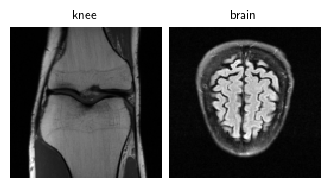

In [3]:
img_size = knee_dataset[0].shape[-2:] # (128, 128)
dinv.utils.plot({
    "knee": knee_dataset[0],
    "brain": brain_dataset[0]
})

Define single-coil MRI physics. We can define a constant Cartesian 4x undersampling mask by sampling once from a physics generator. The mask, data and measurements will all be of shape `(B, C, H, W)` where `C=2` is the real and imaginary parts.

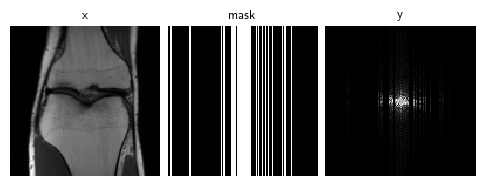

Shapes: torch.Size([1, 2, 128, 128]) torch.Size([1, 2, 128, 128])


In [4]:
physics_generator = dinv.physics.generator.GaussianMaskGenerator(img_size=img_size, acceleration=4, rng=rng, device=device)
mask = physics_generator.step()["mask"]

physics = dinv.physics.MRI(mask=mask, img_size=img_size, device=device)

dinv.utils.plot({
    "x": (x := knee_dataset[0].unsqueeze(0)),
    "mask": mask,
    "y": physics(x).clamp(-1, 1)
})
print("Shapes:", x.shape, physics.mask.shape)

Generate an accelerated single-coil MRI measurement dataset. Use knees for training and brains for testing.

We can also use the physics generator to randomly sample a new mask per sample, and save the masks alongside the measurements:

C:\Users\s2558406\Documents\Repos\deepinv\deepinv\datasets\datagenerator.py:220: UserWarning: Dataset datasets/dinv_dataset0.h5 already exists, skipping...
  warn(f"Dataset {hf_path} already exists, skipping...")


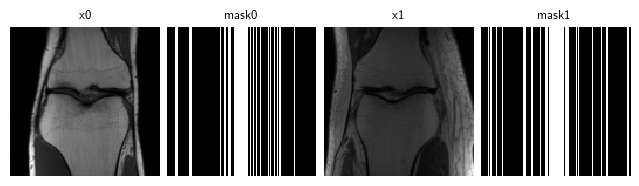

In [5]:
dataset_path = dinv.datasets.generate_dataset(
    train_dataset=knee_dataset,
    test_dataset=brain_dataset,
    val_dataset=None,
    physics=physics,
    physics_generator=physics_generator,
    save_physics_generator_params=True,
    overwrite_existing=False,
    device=device,
    save_dir=dinv.utils.get_data_home(),
    batch_size=1,
)

train_dataset = dinv.datasets.HDF5Dataset(dataset_path, split="train", load_physics_generator_params=True)
test_dataset  = dinv.datasets.HDF5Dataset(dataset_path, split="test",  load_physics_generator_params=True)

dinv.utils.plot({
    "x0":    train_dataset[0][0],
    "mask0": train_dataset[0][2]["mask"],
    "x1":    train_dataset[1][0],
    "mask1": train_dataset[1][2]["mask"],
})

You can also simulate multicoil MRI data. Either pass in ground-truth coil maps, or pass an integer to simulate simple birdcage coil maps. The measurements `y` are now of shape `(B, C, N, H, W)`, where `N` is the coil-dimension.

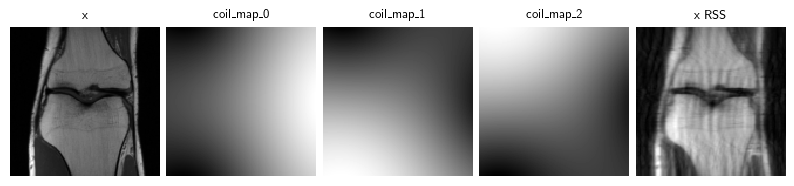

In [6]:
mc_physics = dinv.physics.MultiCoilMRI(img_size=img_size, coil_maps=3, device=device)

dinv.utils.plot({
    "x": x,
    "coil_map_0": mc_physics.coil_maps.abs()[:, 0, ...],
    "coil_map_1": mc_physics.coil_maps.abs()[:, 1, ...],
    "coil_map_2": mc_physics.coil_maps.abs()[:, 2, ...],
    "x RSS": mc_physics.A_adjoint_A(x, mask=mask, rss=True)
})

### 2. Train an accelerated MRI problem with neural networks

Train a neural network to solve the inverse problem. We provide various models specifically used for MRI reconstruction. These are unrolled networks which require a denoiser, such as UNet or DnCNN as a backbone:

In [7]:
denoiser = dinv.models.UNet(
    in_channels=2,
    out_channels=2,
    scales=2,
)

denoiser = dinv.models.DnCNN(
    in_channels=2,
    out_channels=2,
    pretrained=None,
    depth=2,
)

We provide some specific implementations, including [VarNet](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.26977)/[E2E-VarNet](https://arxiv.org/abs/2004.06688) and [MoDL](https://ieeexplore.ieee.org/document/8434321):

In [8]:
model = dinv.models.VarNet(denoiser, num_cascades=2, mode="varnet").to(device)

model = dinv.utils.demo.demo_mri_model(denoiser, num_iter=2, device=device).to(device)

Train a network with supervised or self-supervised (using Equivariant Imaging) loss. 

For speed, we only use a very small 2-layer DnCNN inside a unrolled network with 2 cascades, and train with 5 images for 1 epoch, but load a pretrained model that has been trained with 10 images for 50 epochs:

In [9]:
loss = dinv.loss.SupLoss()
loss = dinv.loss.EILoss(transform=dinv.transform.CPABDiffeomorphism())

trainer = dinv.Trainer(
    model=model,
    physics=physics,
    optimizer=torch.optim.Adam(model.parameters()),
    train_dataloader=(train_dataloader := torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, range(5)))),
    epochs=1,
    show_progress_bar=False,
    save_path=None
)

url = dinv.models.utils.get_weights_url(model_name="demo", file_name="demo_tour_mri.pth")
ckpt = torch.hub.load_state_dict_from_url(url, map_location=lambda storage, loc: storage, file_name="demo_tour_mri.pth")
trainer.model.load_state_dict(ckpt["state_dict"])
trainer.optimizer.load_state_dict(ckpt["optimizer"])

model = trainer.train()
trainer.plot_images = True

The model has 2376 trainable parameters
Train epoch 0: TotalLoss=0.001, PSNR=30.263


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Test the model: we improve the PSNR compared to the zero-filled reconstruction, both on the train (knee) set and the test (brain) set:

Eval epoch 0: PSNR=30.295, PSNR no learning=27.169


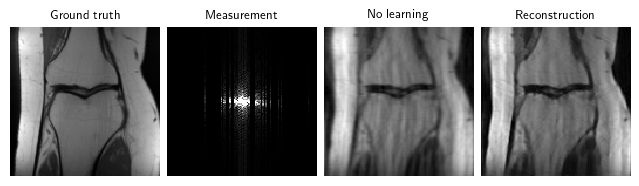

Test results:
PSNR no learning: 27.169 +- 1.845
PSNR: 30.295 +- 1.207


In [10]:
_ = trainer.test(train_dataloader)

Eval epoch 0: PSNR=30.229, PSNR no learning=28.409


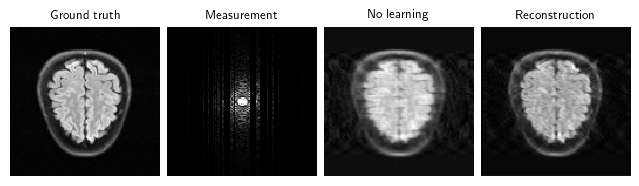

Test results:
PSNR no learning: 28.409 +- 1.409
PSNR: 30.229 +- 1.556


In [11]:
_ = trainer.test(torch.utils.data.DataLoader(torch.utils.data.Subset(test_dataset, range(5))))

### 3. Load raw FastMRI data

The raw multi-coil FastMRI data is provided as pairs of `(x, y)` where `y` are the fully-sampled k-space measurements of arbitrary size, and `x` are the cropped root-sum-square (RSS) magnitude reconstructions.

In [12]:
#dinv.datasets.download_archive(dinv.utils.get_image_url("fastmri_brain_multicoil_train_0.h5"), dinv.utils.get_data_home() / "brain" / "fastmri.h5")

dataset = dinv.datasets.FastMRISliceDataset(dinv.utils.get_data_home() / "brain", slice_index="middle")

x, y = dataset[0]

x, y = x.unsqueeze(0), y.unsqueeze(0)

print("Shapes:", x.shape, y.shape) # x (B, 1, W, W); y (B, C, N, H, W)

img_shape, kspace_shape = x.shape[-2:], y.shape[-2:]
n_coils = y.shape[2]

100%|██████████| 1/1 [00:00<?, ?it/s]

Shapes: torch.Size([1, 1, 320, 320]) torch.Size([1, 2, 20, 640, 320])


We can relate `x` and `y` using our :class:`deepinv.physics.MultiCoilMRI` (note that since we aren't provided with the ground-truth coil-maps, we can only perform the adjoint operator).

In [13]:
physics = dinv.physics.MultiCoilMRI(
    img_size=img_shape,
    mask=torch.ones(kspace_shape),
    coil_maps=torch.ones((n_coils,) + kspace_shape, dtype=torch.complex64),
    device=device
)

x_rss = physics.A_adjoint(y, rss=True, crop=True)

assert torch.allclose(x, x_rss)

### 4. Train using raw data

We now use a mask generator to generate acceleration masks on-the-fly ("online") during training. We use the E2E-VarNet model designed for multicoil MRI. We do not perform coil sensitivity map estimation and simply assume they are flat as above. To do this yourself, pass a model as the `sensitivity_model` parameter.

In [14]:
physics_generator = dinv.physics.generator.GaussianMaskGenerator(img_size=kspace_shape, acceleration=4, rng=rng, device=device)

In [15]:
model = dinv.models.VarNet(denoiser, num_cascades=2, mode="e2e-varnet").to(device)

Note that we require overriding the base :class:`deepinv.training.Trainer` to deal with raw measurements, as we do not want to generate k-space measurements, only mask it.

.. note ::
    
    We require `loop_physics_generator=True` and `shuffle=False` in the dataloader to ensure that each image is always matched with the same random mask at each iteration.

In [16]:
class RawFastMRITrainer(dinv.Trainer):
    def get_samples_online(self, iterators, g):
        # Get data
        x, y = next(iterators[g])
        x, y = x.to(self.device), y.to(self.device)

        # Get physics
        physics = self.physics[g]

        # Generate random mask
        params = self.physics_generator[g].step(batch_size=y.size(0), img_size=y.shape[-2:])

        # Generate measurements directly from raw measurements
        y *= params["mask"]
        
        physics.update_parameters(**params)

        return x, y, physics

We also need to modify the metrics used to crop the model output when comparing to the cropped magnitude RSS targets:

In [17]:
class CropMSE(torch.nn.MSELoss):
    def forward(self, input, target):
        transform = torchvision.transforms.CenterCrop(target.shape[-2:])
        return super().forward(dinv.metric.functional.complex_abs(transform(input)), target)

class CropPSNR(dinv.loss.PSNR):
    def forward(self, x_net = None, x = None, *args, **kwargs):
        transform = torchvision.transforms.CenterCrop(x.shape[-2:])
        return super().forward(transform(x_net), x, *args, **kwargs)

In [18]:
trainer = RawFastMRITrainer(
    model=model,
    physics=physics,
    physics_generator=physics_generator,
    online_measurements=True,
    loop_physics_generator=True,
    losses=dinv.loss.SupLoss(metric=CropMSE()),
    metrics=CropPSNR(),
    optimizer=torch.optim.Adam(model.parameters()),
    train_dataloader=torch.utils.data.DataLoader(dataset, shuffle=False),
    epochs=1,
    save_path=None,
    show_progress_bar=False,
)
_ = trainer.train()

C:\Users\s2558406\Documents\Repos\deepinv\deepinv\training\trainer.py:192: UserWarning: Generated measurements repeat each epoch. Ensure that dataloader is not shuffling.
  warnings.warn(


The model has 2372 trainable parameters


c:\Users\s2558406\Documents\Repos\deepinv\venv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 320, 320])) that is different to the input size (torch.Size([1, 1, 20, 320, 320])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train epoch 0: TotalLoss=0.783, CropPSNR=4.072


### 5. Explore 3D MRI

We use a demo 3D brain volume of shape `(181, 217, 181)` and simulate 3D single-coil or multi-coil Fourier measurements using :class:`deepinv.physics.MRI` or :class:`deepinv.physics.MultiCoilMRI`.

In [ ]:
x = torch.from_numpy(dinv.utils.demo.load_np_url(
    "https://huggingface.co/datasets/deepinv/images/resolve/main/brainweb_t1_ICBM_1mm_subject_0.npy?download=true"
)).unsqueeze(0).unsqueeze(0).to(device)
x = torch.cat([x, torch.zeros_like(x)], dim=1) # add imaginary dimension

print(x.shape) # (B, C, D, H, W) where D is depth

torch.Size([1, 2, 181, 217, 181])

In [35]:
physics = dinv.physics.MultiCoilMRI(img_size=x.shape[1:], three_d=True, device=device)
physics = dinv.physics.MRI(img_size=x.shape[1:], three_d=True, device=device)

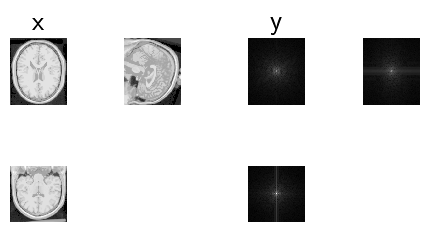

In [38]:
dinv.utils.plot_ortho3D([x, physics(x)], titles=["x", "y"])

### 6. Explore dynamic MRI

Finally, we show how to use the dynamic MRI for image sequence data of shape `(B, C, T, H, W)` where `T` is the time dimension. note that this is also compatible with 3D MRI. We simulate an MRI image sequence using the first 5 knees:

In [41]:
x = torch.stack([knee_dataset[i] for i in range(5)], dim=1).unsqueeze(0)

Generate a Cartesian k-t sampling mask and simulate k-t-space measurements:

In [46]:
physics_generator = dinv.physics.generator.EquispacedMaskGenerator(img_size=img_size, acceleration=4, rng=rng, device=device)
mask = physics_generator.step()["mask"]
physics = dinv.physics.DynamicMRI(mask=mask, img_size=img_size, device=device)

y = physics(x)

print(x.shape, physics(x).shape)

torch.Size([1, 2, 5, 128, 128]) torch.Size([1, 2, 5, 128, 128])
